<div style="display: flex; align-items: center;">
    <img src="https://github.com/nagelt/Teaching_Scripts/raw/9d9e29ecca4b04eaf7397938eacbf116d37ddc93/Images/TUBAF_Logo_blau.png" width="500" height="auto" height="auto" style="margin-right: 100px;" />
    <div>
        <p><strong>Prof. Dr. Thomas Nagel</strong></p>
        <p>Chair of Soil Mechanics and Foundation Engineering<br>Geotechnical Institute<br>Technische Universität Bergakademie Freiberg.</p>
        <p><a href="https://tu-freiberg.de/en/soilmechanics">https://tu-freiberg.de/en/soilmechanics</a></p>
    </div>
</div>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
sp.init_printing()
#Some plot settings
import plot_functions.plot_settings

# Vertical steady-state profiles of hydraulic head / pore water pressure

We will study the impact of inhomogeneous hydraulic conductivity fields using the hydraulic steady-state combination of Darcy's law and the continuity equation:

$$
    0 = \partial_z (k_\text{f} \partial_z h)
$$

We further note that

$$
    \text{d}h = \frac{\text{d}u}{\gamma_\text{w}} + \text{d}z
$$

In [3]:
gamma_w = 10. #kN/m³

## Homeogeneous aquidard

Consider a homogeneous low-permeable layer confined by two aquifers of differing hydraulic heads.

In [4]:
z, h_top, h_bot, H = sp.symbols('z h_top h_bot H', real=True, positive=True)

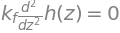

In [5]:

kf = sp.symbols('k_f', real=True, positive=True)
h = sp.Function('h')(z)
DGL = sp.Eq(sp.diff(kf * sp.diff(h, z), z), 0)
DGL

In [6]:
# Integrate DGL twice
h_solution = sp.dsolve(DGL, h)

# Apply boundary conditions
C1, C2 = sp.symbols('C1 C2')
constants = sp.solve([h_solution.rhs.subs(z, 0) - h_bot, h_solution.rhs.subs(z, H) - h_top], (C1, C2))

# General solution with constants
h_solution = h_solution.subs(constants)
h_solution

The result for a constant $k_\text{f}$ value is the expected linear distribution between the two boundary potentials:

$$
    h(z) = h_\text{bot} + (h_\text{top} - h_\text{bot}) \frac{z}{H}
$$

## Inhomogeneous aquidard

Now we look at a layer whose hydraulic conductivity decreases with depth.

$$
    k_\text{f}(z) = k_\text{bot} \left( \frac{k_\text{top}}{k_\text{bot}} \right)^{\frac{z}{H}}
$$

In [7]:
k_to_kbot = lambda zeta, k_top_to_k_bot: k_top_to_k_bot**zeta

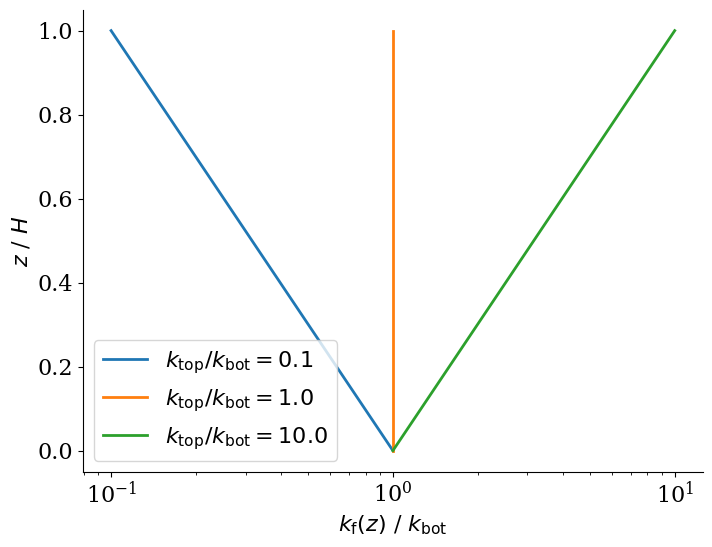

In [8]:
zeta_vals = np.linspace(0, 1, 3)
fig, ax = plt.subplots()

for i in [0.1, 1, 10]:
    ax.plot(k_to_kbot(zeta_vals, i), zeta_vals, label=r'$k_\mathrm{top}/k_\mathrm{bot} = %.1f$' % i)

ax.legend()
ax.set_ylabel(r'$z$ / $H$')
ax.set_xlabel(r'$k_\text{f}(z)$ / $k_\mathrm{bot}$')
ax.set_xscale('log')

In [9]:
k_top, k_bot = sp.symbols('k_top k_bot', real=True, positive=True)
kf = k_bot * sp.Pow(k_top/k_bot, z/H)
kf


In [10]:
h = sp.Function('h')(z)
DGL = sp.Eq(sp.diff(kf * sp.diff(h, z), z), 0)

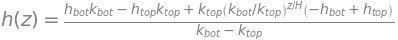

In [11]:
# Integrate DGL twice
h_solution = sp.dsolve(DGL, h)

# Apply boundary conditions
C1, C2 = sp.symbols('C1 C2')
constants = sp.solve([h_solution.rhs.subs(z, 0) - h_bot, h_solution.rhs.subs(z, H) - h_top], (C1, C2))

# General solution with constants
h_solution = h_solution.subs(constants)
h_anom = h_solution.simplify()
h_anom

Die resultierende Verteilung der hydraulischen Höhe ist nichtlinear:

$$
    h(z) = \frac{h_\text{bot} k_\text{bot} - h_\text{top} k_\text{top}}{k_\text{bot} - k_\text{top}} + \frac{h_\text{top} - h_\text{bot}}{k_\text{bot} - k_\text{top}} k_\text{top} \left( \frac{k_\text{bot}}{k_\text{top}} \right)^{\frac{z}{H}}
$$

In [12]:
def h_anom_np(zeta, h_bot, h_top, k_bot, k_top):
    term1 = (h_bot * k_bot - h_top * k_top) / (k_bot - k_top)
    term2 = (h_top - h_bot) / (k_bot - k_top) * k_top * (k_bot / k_top) ** (zeta)
    return term1 + term2

In [13]:
def h_solution_np(zeta, h_bot, h_top):
    return h_bot + (h_top - h_bot) * (zeta)

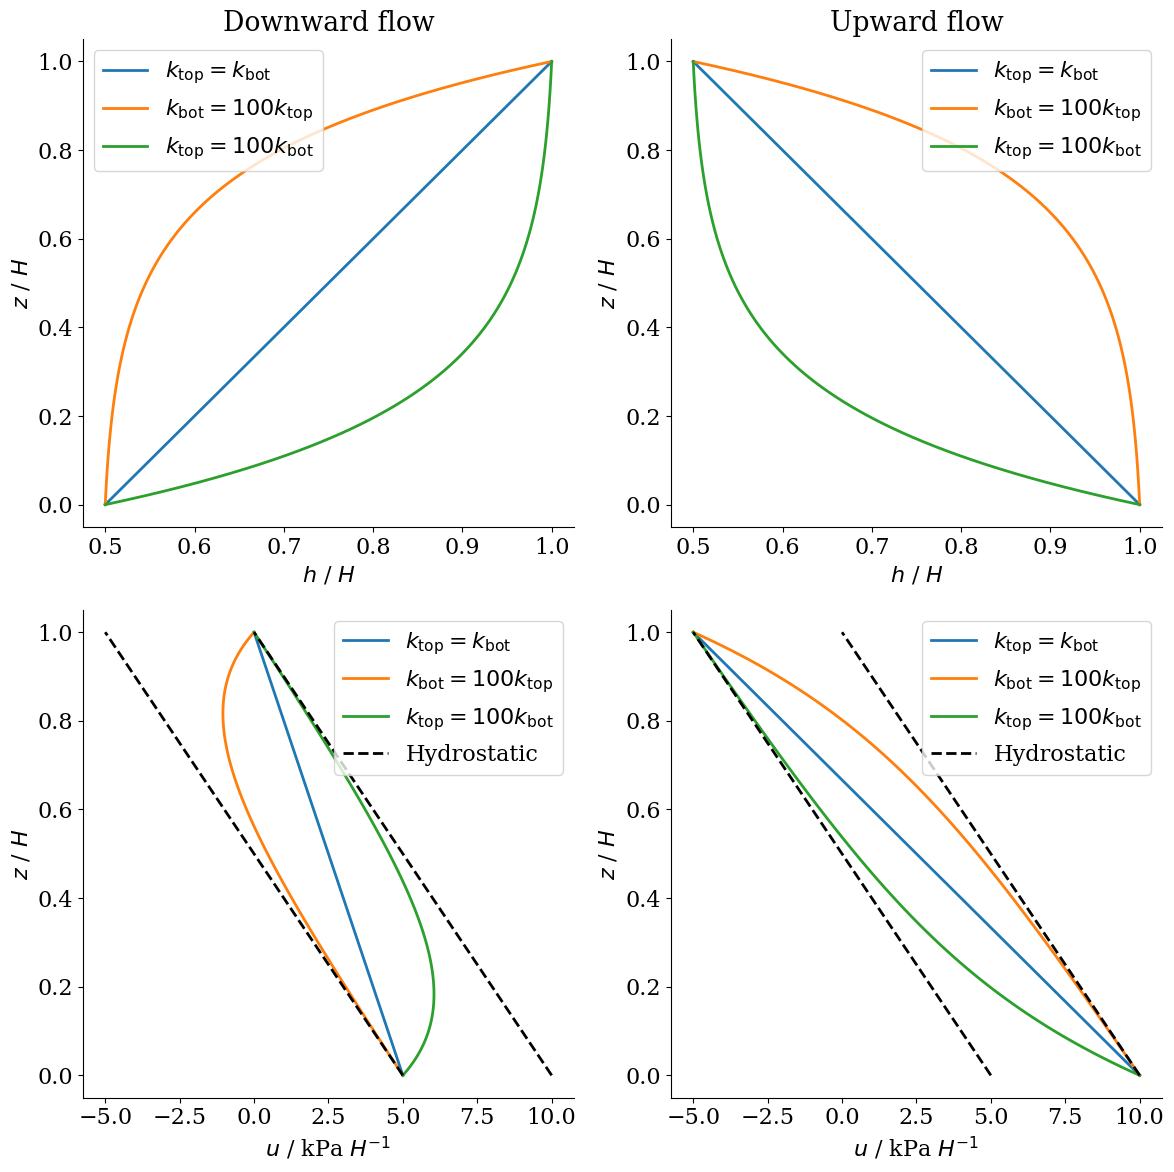

In [14]:
zeta_vals = np.linspace(0, 1, 100)
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

# Top row: h_solution_np and h_anom_np
ax[0, 0].set_title('Downward flow')
ax[0, 0].plot(h_solution_np(zeta_vals, 0.5, 1), zeta_vals, label=r'$k_\mathrm{top} = k_\mathrm{bot}$')
ax[0, 0].plot(h_anom_np(zeta_vals, 0.5, 1, 1e-1, 1e-3), zeta_vals, label=r'$k_\mathrm{bot} = 100 k_\mathrm{top}$')
ax[0, 0].plot(h_anom_np(zeta_vals, 0.5, 1, 1e-3, 1e-1), zeta_vals, label=r'$k_\mathrm{top} = 100 k_\mathrm{bot}$')

ax[0, 1].set_title('Upward flow')
ax[0, 1].plot(h_solution_np(zeta_vals, 1, 0.5), zeta_vals, label=r'$k_\mathrm{top} = k_\mathrm{bot}$')
ax[0, 1].plot(h_anom_np(zeta_vals, 1, 0.5, 1e-1, 1e-3), zeta_vals, label=r'$k_\mathrm{bot} = 100 k_\mathrm{top}$')
ax[0, 1].plot(h_anom_np(zeta_vals, 1, 0.5, 1e-3, 1e-1), zeta_vals, label=r'$k_\mathrm{top} = 100 k_\mathrm{bot}$')

u_from_head = lambda h, z: (h-z)*gamma_w

# Bottom row: u_from_head
ax[1, 0].plot(u_from_head(h_solution_np(zeta_vals, 0.5, 1), zeta_vals), zeta_vals, label=r'$k_\mathrm{top} = k_\mathrm{bot}$')
ax[1, 0].plot(u_from_head(h_anom_np(zeta_vals, 0.5, 1, 1e-1, 1e-3), zeta_vals), zeta_vals, label=r'$k_\mathrm{bot} = 100 k_\mathrm{top}$')
ax[1, 0].plot(u_from_head(h_anom_np(zeta_vals, 0.5, 1, 1e-3, 1e-1), zeta_vals), zeta_vals, label=r'$k_\mathrm{top} = 100 k_\mathrm{bot}$')
ax[1, 0].plot(-gamma_w*zeta_vals+1*gamma_w,zeta_vals,color='black',linestyle='--',label='Hydrostatic')
ax[1, 0].plot(-gamma_w*zeta_vals+0.5*gamma_w,zeta_vals,color='black',linestyle='--')


ax[1, 1].plot(u_from_head(h_solution_np(zeta_vals, 1, 0.5), zeta_vals), zeta_vals, label=r'$k_\mathrm{top} = k_\mathrm{bot}$')
ax[1, 1].plot(u_from_head(h_anom_np(zeta_vals, 1, 0.5, 1e-1, 1e-3), zeta_vals), zeta_vals, label=r'$k_\mathrm{bot} = 100 k_\mathrm{top}$')
ax[1, 1].plot(u_from_head(h_anom_np(zeta_vals, 1, 0.5, 1e-3, 1e-1), zeta_vals), zeta_vals, label=r'$k_\mathrm{top} = 100 k_\mathrm{bot}$')
ax[1, 1].plot(-gamma_w*zeta_vals+0.5*gamma_w,zeta_vals,color='black',linestyle='--',label='Hydrostatic')
ax[1, 1].plot(-gamma_w*zeta_vals+gamma_w,zeta_vals,color='black',linestyle='--')


for i in range(2):
    for j in range(2):
        ax[i, j].legend()
        ax[i, j].set_ylabel(r'$z$ / $H$')
        ax[i, j].set_xlabel(r'$h$ / $H$' if i == 0 else r'$u$ / kPa $H^{-1}$')

fig.tight_layout()

One can observe how non-linear pore water pressure / head distributions result from inhomogeneous conductivity fields.

Conversely, one can re-construct hypothetical $k_\text{f}$ fields from head measurements and compare them to test data.

# Thermal effects

For non-constant density the 1D Mass balance reads

$$
    0 = \partial_z (\varrho_\text{f} v_z) = \partial_z \varrho_\text{f} v_z + \varrho_\text{f} \partial_z v_z
$$

Let's assume a fixed geothermal gradient $\partial_z T$, so that $\partial_z \varrho_\text{f} = - \varrho_\text{f} \beta_T \partial_z T$. We then find by substitution into the mass balance 

\begin{align}
    \beta_T \partial_z T &= v_z^{-1} \partial_z v_z
    \\
    \int \limits_{T_0}^{T_1} \beta_T\, \text{d} T &= \int \limits_{v_0}^{v_1} v_z^{-1}\, \text{d} v_z
    \\
    \beta_T \Delta T &= \ln \frac{v_1}{v_0}
\end{align}

In other words, we find

$$
    v_1 = v_0 \exp (\beta_T \Delta T)
$$

or

$$
    \partial_z v_z = \beta_T v_z \partial_z T
$$

With $\beta_T = 2\cdot 10^{-4}\,\text{K}^{-1}$, a $\Delta T = 10\,\text{K}$ yields $0.2\,\%$ density change, and a relative velocity change of $0.2\,\%$ as well. Due to 

$$
    v_z = - \frac{k}{\mu} (\partial_z p - \varrho_\text{f} g)
$$

we find

$$
    \partial_z p = -\frac{\mu}{k} v_z + \varrho_\text{f} g
$$

The change in pressure gradient with depth is for a constant permeability

\begin{align}
    \partial^2_z p &= - \partial_z \mu\, k^{-1} v_z - \frac{\mu}{k} \partial_z v_z + \partial_z \varrho_\text{f} g
    \\
    &= \left[ - \frac{\partial \mu}{\partial T} k^{-1} v_z - \frac{\mu}{k} \beta_T v_z - \varrho_\text{f} \beta_T g\right] \partial_z T
    \\
    %&= \left[ - \frac{\partial \mu}{\partial T} k^{-1} v_z + \beta_T \partial_z p - \beta_T \varrho_\text{f} g - \varrho_\text{f} \beta_T g\right] \partial_z T
    %\\
    &\approx \left[ - (-10^{-2} 10^{20}  + 10^{-3} 10^{20} 10^{-4} ) 10^{-20} 10^{3} 10^3 10 - 10^3 10^{-4} 10 \right] 10^{-2}
    \\
    &\approx \left[ 10^{5} - 10^{0} - 10^0 \right] 10^{-2}
\end{align}

The temperature-dependent viscosity has the largest impact on the pressure profile by far. (todo: add units to ooms)

Alternative:

$$
    \partial_z v_z |_{(\partial_z p - \varrho_\text{f} g)} = - \frac{k}{\mu} (\partial_z p - \varrho_\text{f} g) \left( - \frac{1}{\mu} \partial_T \mu \partial_z T\right)
$$

The relative change in velocity for $\Delta T = 10\,$K is thus on the order of  $ - \frac{1}{\mu} \partial_T \mu \partial_z T \approx 10^3 10^{-2} 10^1 = 10^2$, which is also 5 oom larger than the $10^{-3}$ arrived at before.

In [41]:
mu = lambda T: 1.856e-14 * np.exp(4209/T + 0.04527 * T - 3.376e-5 *T*T)
df_dT = lambda f, T: (f(T*(1+1e-8)) - f(T*(1-1e-8)))/2e-8

Text(0, 0.5, '$\\partial_T \\mu$ / Pa s K$^{-1}$')

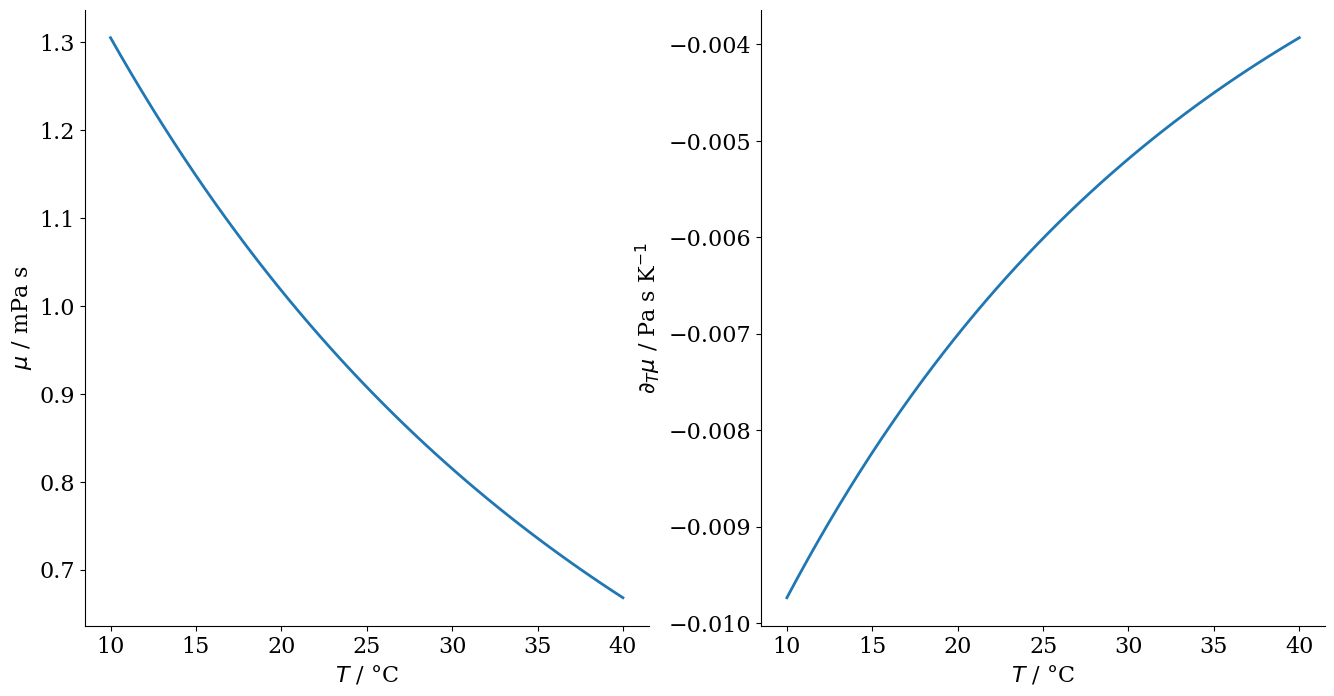

In [40]:
temps = np.linspace(10,40)
fig, ax = plt.subplots(ncols=2,figsize=(16,8))
ax[0].plot(temps, mu(temps+273.15)*1e3)
ax[0].set_xlabel('$T$ / °C')
ax[0].set_ylabel(r'$\mu$ / mPa s')

ax[1].plot(temps, df_dT(mu,temps+273.15))
ax[1].set_xlabel('$T$ / °C')
ax[1].set_ylabel(r'$\partial_T \mu$ / Pa s K$^{-1}$')

## Thermo-osmosis

Let's assume the following extension to Darcy's law:

$$
    v_z = - k_\text{f} \partial_z h - \epsilon_T k_\text{f} \partial_z T
$$

With $[\epsilon_T] = \text{m}\,\text{K}^{-1}$, so that $[k_T] = [\epsilon_T k_\text{f}] = \text{m}^2\,\text{K}^{-1}\,\text{s}^{-1}$.

### Constant properties

Let us further assume that $k_\text{f} = \text{const.}$ and $\epsilon_T = \text{const.}$

Then, mass conservation yields

$$
    0 = \partial_z (\partial_z h + \epsilon_T \partial_z T)
$$

Integration yields

\begin{align*}
    0 &= \partial_z h + \epsilon_T \partial_z T + C_1
    \\
    0 &= h + (\epsilon_T \partial_z T + C_1) z + C_2
\end{align*}

This yields the same result as above:
$$
    h(z) = h_\text{bot} + (h_\text{top} - h_\text{bot}) \frac{z}{H}
$$

To would thus modify the flux but not the pressure profile.

For the latter, heterogeneity is important, be it in the geothermal gradient, the TO coefficient or the hydraulic conductivity.

###

### Variable properties

Consider two layers with variable properties. This leads to the linear system

\begin{align}
    0 &= v_z + k_\text{f}^1 \frac{\Delta h^1}{\Delta z_1} + \epsilon_T^1 k_\text{f}^1 \partial_z T
    \\
    0 &= v_z + k_\text{f}^2 \frac{\Delta h^2}{\Delta z_2} + \epsilon_T^2 k_\text{f}^2 \partial_z T
    \\
    \Delta h &= \Delta h_1 + \Delta h_2
\end{align}

Let's pick some values:

In [139]:
dT_dz = 0.08 #K/m, Mont Terri

In [156]:
kf = np.array([1e-13,2e-13])
eT = np.array([1.5e2,1.0e2])
dz = np.array([10,10])
dh = 10

In [157]:
A = np.array([[1,kf[0]/dz[0],0],
              [1,0,kf[1]/dz[1]],
              [0,1,1]])
A

array([[1.e+00, 1.e-14, 0.e+00],
       [1.e+00, 0.e+00, 2.e-14],
       [0.e+00, 1.e+00, 1.e+00]])

In [158]:
RHS = np.array([-eT[0]*kf[0]*dT_dz,-eT[1]*kf[1]*dT_dz,10])
RHS

array([-1.2e-12, -1.6e-12,  1.0e+01])

In [159]:
np.linalg.solve(A,RHS)

array([-1.4e-12,  2.0e+01, -1.0e+01])

### Link to TF

Todo:
* TF und TO mit Onsager. Link von $\partial_z T$ und $\partial_z p$